In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm

import mltools.utils.cuda_tools as cuda_tools
device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import importlib
importlib.reload(utils)

memory_available [77651]
best GPU: 0


<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/notebooks/../utils.py'>

In [2]:
os.chdir('/n/home12/cfpark00/ML/ToyCompDiff')

In [4]:
#os.chdir('/n/home12/cfpark00/ML/vectorCG')
plot_datas=[]
acc_sigma=5
ignore_nuisance=True
det_model=False#True
for fol in glob.glob("./data/base/seed*"):
#for fol in glob.glob("./data/data_noise/dn=1e-05_seed*"):
#for fol in glob.glob("./data/det/seed*"):
#for fol in glob.glob("./data/dim=4/seed*"):
#for fol in glob.glob("./data/h64/base/seed*"):
#for fol in glob.glob("./data/init_scales/seed*"):
#for fol in glob.glob("./data/nuisance/dn=3_seed*"):
#for fol in glob.glob("./data/nuisance_det/dn=5_seed*"):
#for fol in glob.glob("./data/perdim=3/seed*"):
#for fol in glob.glob("./data/perdim=5/seed*"):
#for fol in glob.glob("./data/perdim=6/seed*"):
#for fol in glob.glob("./data/perdim=4_dim=4/seed*"):
    config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_file)
    logs_file=os.path.join(fol,"logs.pth")
    logs=torch.load(logs_file)

    x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)
    n_classes=len(config["means"])
    #losses
    loss_keys=["elbo","diffusion_loss","latent_loss","reconstruction_loss"]
    if det_model:
        losses_perclass={l:[] for l in range(n_classes)}
    else:
        loss_keys=["elbo","diffusion_loss","latent_loss","reconstruction_loss"]
        losses_perclass={l:dict(zip(loss_keys,[[] for _ in range(len(loss_keys))])) for l in range(n_classes)}
    ckpts=[]
    gens_tr=[]
    gens_te=[]
    model=utils.get_model(config)
    for ckpt_path in tqdm.tqdm(logs["ckpt_paths"]):
        if "h64" in fol:
            print("For h64, changing ckpt path")
            ckpt_path=ckpt_path.replace("/base/","/h64/base/")
        ckpt=torch.load(ckpt_path)
        if not det_model:
            for key in list(ckpt.keys()):
                if key[:4]=="net.":
                    del ckpt[key]
        ckpts.append(ckpt)
        model.load_state_dict(ckpt)
        model=model.to(device)
        x_tr_torch=torch.tensor(x_tr).to(device=device,dtype=torch.float32)
        y_tr_torch=torch.tensor(y_tr).to(device=device,dtype=torch.float32)
        x_te_torch=torch.tensor(x_te).to(device=device,dtype=torch.float32)
        y_te_torch=torch.tensor(y_te).to(device=device,dtype=torch.float32)
        ##loss
        with torch.no_grad():
            if det_model:
                loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none").mean(-1)
                loss_te=model.get_loss(x=x_te_torch,c=y_te_torch,reduction="none").mean(-1)
            else:
                loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none")[1]#decomposed loss
                loss_te=model.get_loss(x=x_te_torch,c=y_te_torch,reduction="none")[1]#decomposed loss
        if det_model:
            for l in range(n_classes):
                in_tr=np.any(l_tr==l)
                if in_tr:
                    losses_perclass[l].append(loss_tr[l_tr==l].cpu().numpy())
                else:
                    losses_perclass[l].append(loss_te[l_te==l].cpu().numpy())
        else:
            for loss_key in loss_keys:
                for l in range(n_classes):
                    in_tr=np.any(l_tr==l)
                    if in_tr:
                        losses_perclass[l][loss_key].append(loss_tr[loss_key][l_tr==l].cpu().numpy())
                    else:
                        losses_perclass[l][loss_key].append(loss_te[loss_key][l_te==l].cpu().numpy())
        ##
        with torch.no_grad():
            gen_tr=model.generate(y_tr_torch).detach().cpu().numpy()
            gen_te=model.generate(y_te_torch).detach().cpu().numpy()
        gens_tr.append(gen_tr)
        gens_te.append(gen_te)
    if det_model:
        for l in range(n_classes):
            losses_perclass[l]=np.stack(losses_perclass[l],axis=0)
    else:
        for l in range(n_classes):
            for loss_key in loss_keys:
                losses_perclass[l][loss_key]=np.stack(losses_perclass[l][loss_key],axis=0)

    gens_tr=np.stack(gens_tr,axis=0)
    gens_te=np.stack(gens_te,axis=0)

    save_steps=logs["save_steps"]
    losses=np.array(logs["losses"])
    val_losses=np.array(logs["val_losses"])
    te_losses=np.array(logs["te_losses"])

    means=np.array(config["means"])
    covs=np.array(config["covs"])
    if not ignore_nuisance:
        if "dim_nuisance" in config:
            if "nl_nuisance" in config and config["nl_nuisance"]:
                assert False
            else:
                n,d,dn=means.shape[0],means.shape[1],config["dim_nuisance"]
                nuisance_scale=config.get("nuisance_scale",1.0)
                means=np.concatenate([means,np.zeros((n,dn))],axis=1)
                nuisance_cov=(np.eye(dn)*nuisance_scale**2)[None,:,:].repeat(n,axis=0)
                covs_=np.zeros((n,d+dn,d+dn))
                covs_[:,:d,:d]=covs
                covs_[:,d:,d:]=nuisance_cov
                covs=covs_
                dim=d+dn
        invcovs=np.stack([np.linalg.inv(cov) for cov in covs],axis=0)
        means_sqdist_tr=np.power( (gens_tr-means[l_tr]).mean(1),2 ).mean(1)
        means_sqdist_te=np.power( (gens_te-means[l_te]).mean(1),2 ).mean(1)
    else:
        dim=means.shape[1]
        invcovs=np.stack([np.linalg.inv(cov) for cov in covs],axis=0)
        means_sqdist_tr=np.power( (gens_tr[:,:,:dim]-means[l_tr]).mean(1),2 ).mean(1)
        means_sqdist_te=np.power( (gens_te[:,:,:dim]-means[l_te]).mean(1),2 ).mean(1)

    means_sqdist_perclass={}
    for l in range(n_classes):
        in_tr=np.any(l_tr==l)
        if in_tr:
            means_sqdist_perclass[l]=np.power( (gens_tr[:,l_tr==l,:dim]-means[l]).mean(1),2 ).mean(1)
        else:
            means_sqdist_perclass[l]=np.power( (gens_te[:,l_te==l,:dim]-means[l]).mean(1),2 ).mean(1)

    dev_tr=gens_tr[:,:,:dim]-means[l_tr]
    dev_te=gens_te[:,:,:dim]-means[l_te]
    z_tr=np.einsum("tbi,bij,tbj->tb",dev_tr,invcovs[l_tr],dev_tr)/means.shape[-1]
    z_te=np.einsum("tbi,bij,tbj->tb",dev_te,invcovs[l_te],dev_te)/means.shape[-1]
    accs_tr=(z_tr<acc_sigma).astype(np.float32).mean(-1)
    accs_te=(z_te<acc_sigma).astype(np.float32).mean(-1)
    accs_perclass={}
    for l in range(n_classes):
        in_tr=np.any(l_tr==l)
        if in_tr:
            accs_perclass[l]=(z_tr[:,l_tr==l]<acc_sigma).astype(np.float32).mean(-1)
        else:
            accs_perclass[l]=(z_te[:,l_te==l]<acc_sigma).astype(np.float32).mean(-1)

    plot_data={}
    plot_data["gens_tr"]=gens_tr
    plot_data["gens_te"]=gens_te
    plot_data["min_vlb"]=model.get_min_vlb() if hasattr(model,"get_min_vlb") else 0
    plot_data["save_steps"]=save_steps
    plot_data["losses"]=losses
    plot_data["val_losses"]=val_losses
    plot_data["te_losses"]=te_losses
    plot_data["means_sqdist_tr"]=means_sqdist_tr
    plot_data["means_sqdist_te"]=means_sqdist_te
    plot_data["means_sqdist_perclass"]=means_sqdist_perclass
    plot_data["losses_perclass"]=losses_perclass
    plot_data["accs_perclass"]=accs_perclass
    plot_data["accs_tr"]=accs_tr
    plot_data["accs_te"]=accs_te
    plot_data["ckpts"]=ckpts
    plot_datas.append(plot_data)

100%|██████████| 60/60 [00:10<00:00,  5.57it/s]


In [5]:
n_classes=config["n_classes"]
tri=np.nonzero(config["n_samples_train"])[0]

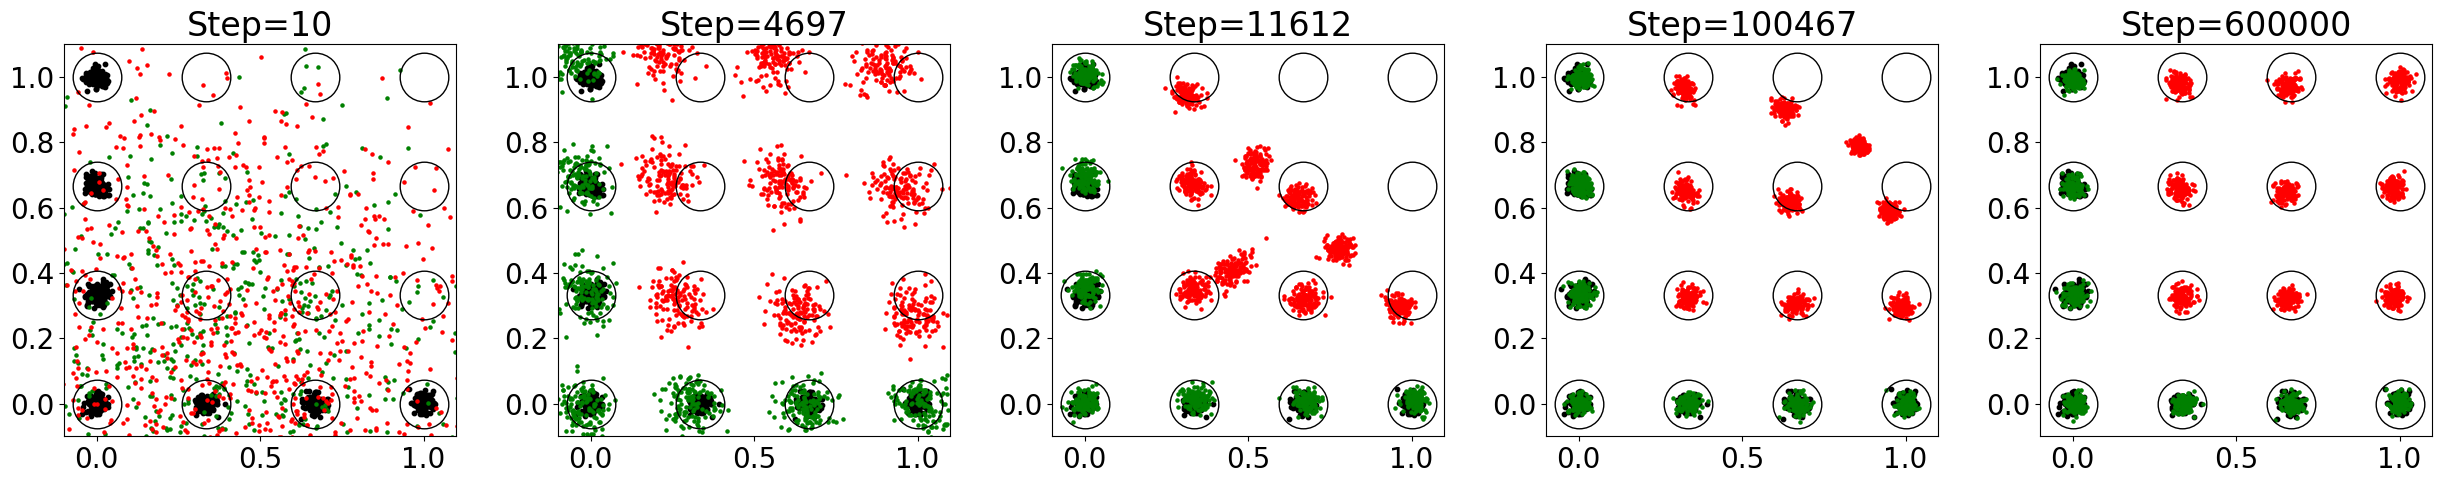

In [6]:
cmap=plt.get_cmap("coolwarm")
plt.figure(figsize=(25,5))
plt.rcParams.update({'font.size': 20})
c=0
for i in [0,5,8,24,59]:
    plt.subplot(1,5,c+1)
    plt.scatter(x_tr[:,0],x_tr[:,1],c="black",s=10)
    #draw circles
    means=np.array(config["means"])
    plt.plot(means[:,0],means[:,1],c="black",ms=35,marker="o",mfc='none',ls="None")

    plt.scatter(gens_tr[i,:,0],gens_tr[i,:,1],s=5,c="g")
    plt.scatter(gens_te[i,:,0],gens_te[i,:,1],s=5,c="r")
    plt.title(f"Step={save_steps[i]}")
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.gca().set_aspect('equal')
    c+=1
plt.tight_layout()
plt.savefig("./figures/training_progress.png")

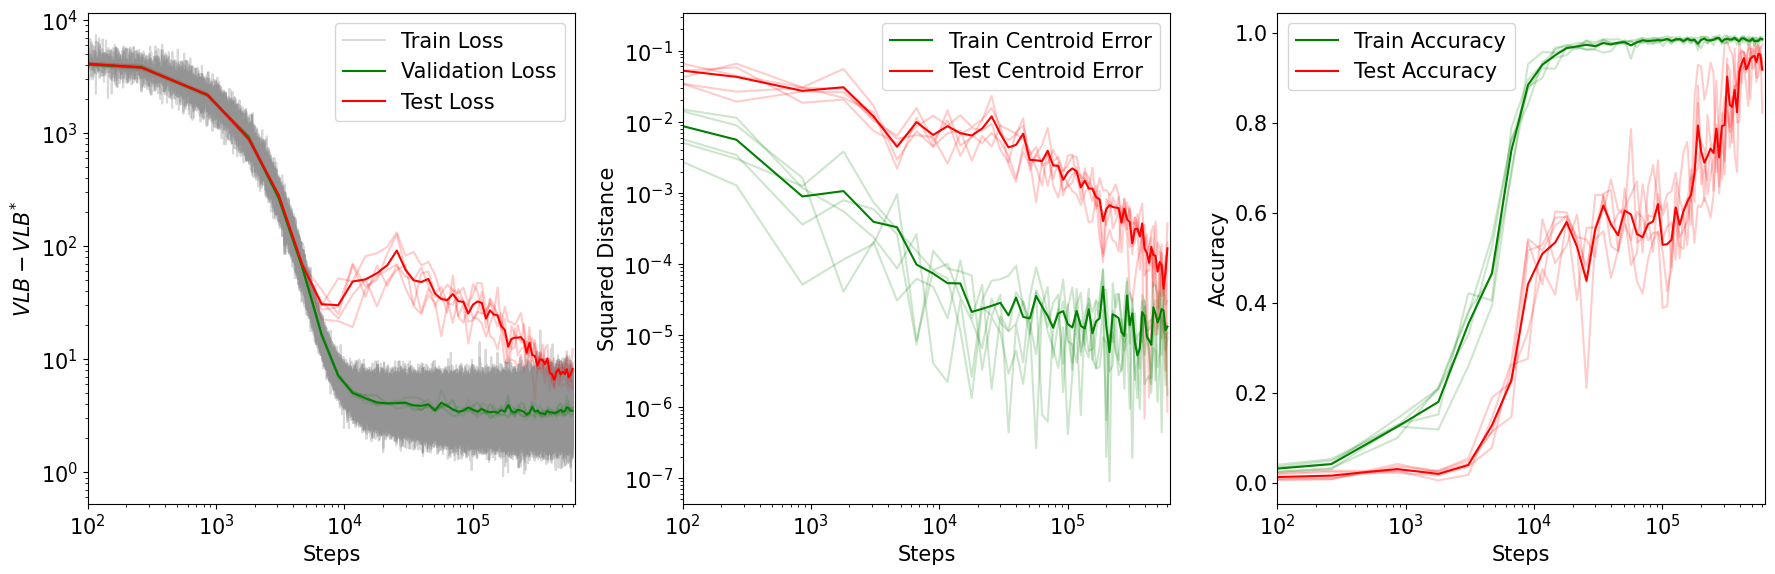

In [7]:
x_left=100

plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 15})
plt.subplot(1,3,1)
val_lossess=[]
te_lossess=[]
for i,plot_data in enumerate(plot_datas):
    min_vlb=plot_data["min_vlb"]
    save_steps=plot_data["save_steps"]
    losses=plot_data["losses"]
    val_losses=plot_data["val_losses"]
    val_lossess.append(val_losses)
    te_losses=plot_data["te_losses"]
    te_lossess.append(te_losses)
    plt.plot(losses-min_vlb,c="gray",alpha=0.3,label="Train Loss" if i==0 else None)
    plt.plot(save_steps,val_losses-min_vlb,c="green",alpha=0.2)
    plt.plot(save_steps,te_losses-min_vlb,c="red",alpha=0.2)
val_lossess=np.stack(val_lossess,axis=0)
te_lossess=np.stack(te_lossess,axis=0)
vl_m=val_lossess.mean(0)
tl_m=te_lossess.mean(0)
plt.plot(save_steps,vl_m-min_vlb,label="Validation Loss",c="green")
plt.plot(save_steps,tl_m-min_vlb,label="Test Loss",c="red")
plt.xlim(left=x_left)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel(r"$VLB-VLB^{*}$")
plt.legend()

plt.subplot(1,3,2)
means_sqdist_trs=[]
means_sqdist_tes=[]
for i,plot_data in enumerate(plot_datas):
    means_sqdist_tr=plot_data["means_sqdist_tr"]
    means_sqdist_te=plot_data["means_sqdist_te"]
    means_sqdist_trs.append(means_sqdist_tr)
    means_sqdist_tes.append(means_sqdist_te)
    plt.plot(save_steps,means_sqdist_tr,c="green",alpha=0.2)
    plt.plot(save_steps,means_sqdist_te,c="red",alpha=0.2)
means_sqdist_trs=np.stack(means_sqdist_trs,axis=0)
means_sqdist_tes=np.stack(means_sqdist_tes,axis=0)
mdtr_m=means_sqdist_trs.mean(0)
mdte_m=means_sqdist_tes.mean(0)
plt.plot(save_steps,mdtr_m,label="Train Centroid Error",c="green")
plt.plot(save_steps,mdte_m,label="Test Centroid Error",c="red")
plt.xlim(left=x_left)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Squared Distance")
plt.legend()

plt.subplot(1,3,3)
accs_trs=[]
accs_tes=[]
for i,plot_data in enumerate(plot_datas):
    accs_tr=plot_data["accs_tr"]
    accs_te=plot_data["accs_te"]
    accs_trs.append(accs_tr)
    accs_tes.append(accs_te)
    plt.plot(save_steps,accs_tr,c="green",alpha=0.2)
    plt.plot(save_steps,accs_te,c="red",alpha=0.2)
accs_trs=np.stack(accs_trs,axis=0)
accs_tes=np.stack(accs_tes,axis=0)
acctr_m=accs_trs.mean(0)
accte_m=accs_tes.mean(0)
plt.plot(save_steps,acctr_m,label="Train Accuracy",c="green")
plt.plot(save_steps,accte_m,label="Test Accuracy",c="red")
plt.xlim(left=x_left)
plt.xscale("log")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

plt.savefig("./figures/diffusion_concept_grokking.png")

In [77]:
tri=np.nonzero(config["n_samples_train"])[0]
means=np.array(config["means"])
md_from_orig=means.sum(1)
in_hull=md_from_orig<=(1.+1e-5)
out_of_hull=md_from_orig>(1.+1e-5)
i_in_hull=np.nonzero(in_hull)[0]
i_out_of_hull=np.nonzero(out_of_hull)[0]
i_in_hull=np.array(list(set(list(i_in_hull))-set(list(tri))))
len(tri),len(i_out_of_hull),len(i_in_hull)

(7, 6, 3)

In [78]:
md_from_orig

array([0.        , 0.33333333, 0.66666667, 1.        , 0.33333333,
       0.66666667, 1.        , 1.33333333, 0.66666667, 1.        ,
       1.33333333, 1.66666667, 1.        , 1.33333333, 1.66666667,
       2.        ])

In [79]:
md_from_hull=np.zeros(n_classes)
md_from_tri=np.zeros(n_classes)
trimeans=means[tri]
for l in range(n_classes):
    mean=means[l]
    md_from_tri[l]=np.linalg.norm(trimeans-mean,axis=1).min()
    sd=mean.sum()
    d_diag=1/3/np.sqrt(2)
    if sd<=1+1e-5:
        md_from_hull[l]=0.
    elif sd<1.4:
        md_from_hull[l]=d_diag
    elif sd<1.8:
        md_from_hull[l]=2*d_diag
    else:
        md_from_hull[l]=3*d_diag

In [80]:
md_sqdist=[]
for i,plot_data in enumerate(plot_datas):
    means_sqdist_perclass=plot_data["means_sqdist_perclass"]
    for l in range(n_classes):
        md_sqdist.append(means_sqdist_perclass[l])
md_sqdist=np.stack(md_sqdist,axis=0)
md_sqdist.shape

(80, 60)

In [81]:
uniques_from_hull=np.unique(md_from_hull)
uniques_from_tri=np.unique(md_from_tri)
md_from_hull_=md_from_hull[None].repeat(5,axis=0).flatten()
md_from_tri_=md_from_tri[None].repeat(5,axis=0).flatten()

In [85]:
import scipy.stats as sstats
i=8
bin_edges=np.append(uniques_from_hull-1e-3,np.inf)
means_from_hull=sstats.binned_statistic(md_from_hull_,md_sqdist[:,i],statistic="mean",bins=bin_edges).statistic
stds_from_hull=sstats.binned_statistic(md_from_hull_,md_sqdist[:,i],statistic="std",bins=bin_edges).statistic
bin_edges=np.append(uniques_from_tri-1e-3,np.inf)
means_from_tri=sstats.binned_statistic(md_from_tri_,md_sqdist[:,i],statistic="mean",bins=bin_edges).statistic
stds_from_tri=sstats.binned_statistic(md_from_tri_,md_sqdist[:,i],statistic="std",bins=bin_edges).statistic

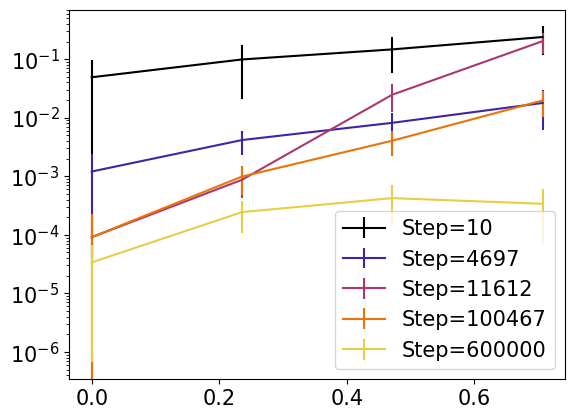

In [100]:
cmap=plt.get_cmap("CMRmap")
for count,i in enumerate([0,5,8,24,59]):
    bin_edges=np.append(uniques_from_hull-1e-3,np.inf)
    means_from_hull=sstats.binned_statistic(md_from_hull_,md_sqdist[:,i],statistic="mean",bins=bin_edges).statistic
    stds_from_hull=sstats.binned_statistic(md_from_hull_,md_sqdist[:,i],statistic="std",bins=bin_edges).statistic
    bin_edges=np.append(uniques_from_tri-1e-3,np.inf)
    means_from_tri=sstats.binned_statistic(md_from_tri_,md_sqdist[:,i],statistic="mean",bins=bin_edges).statistic
    stds_from_tri=sstats.binned_statistic(md_from_tri_,md_sqdist[:,i],statistic="std",bins=bin_edges).statistic

    plt.errorbar(uniques_from_hull,means_from_hull,yerr=stds_from_hull,label=f"Step={save_steps[i]}",color=cmap(count/5))
    #plt.errorbar(uniques_from_tri,means_from_tri,yerr=stds_from_tri)
plt.yscale("log")
plt.legend()

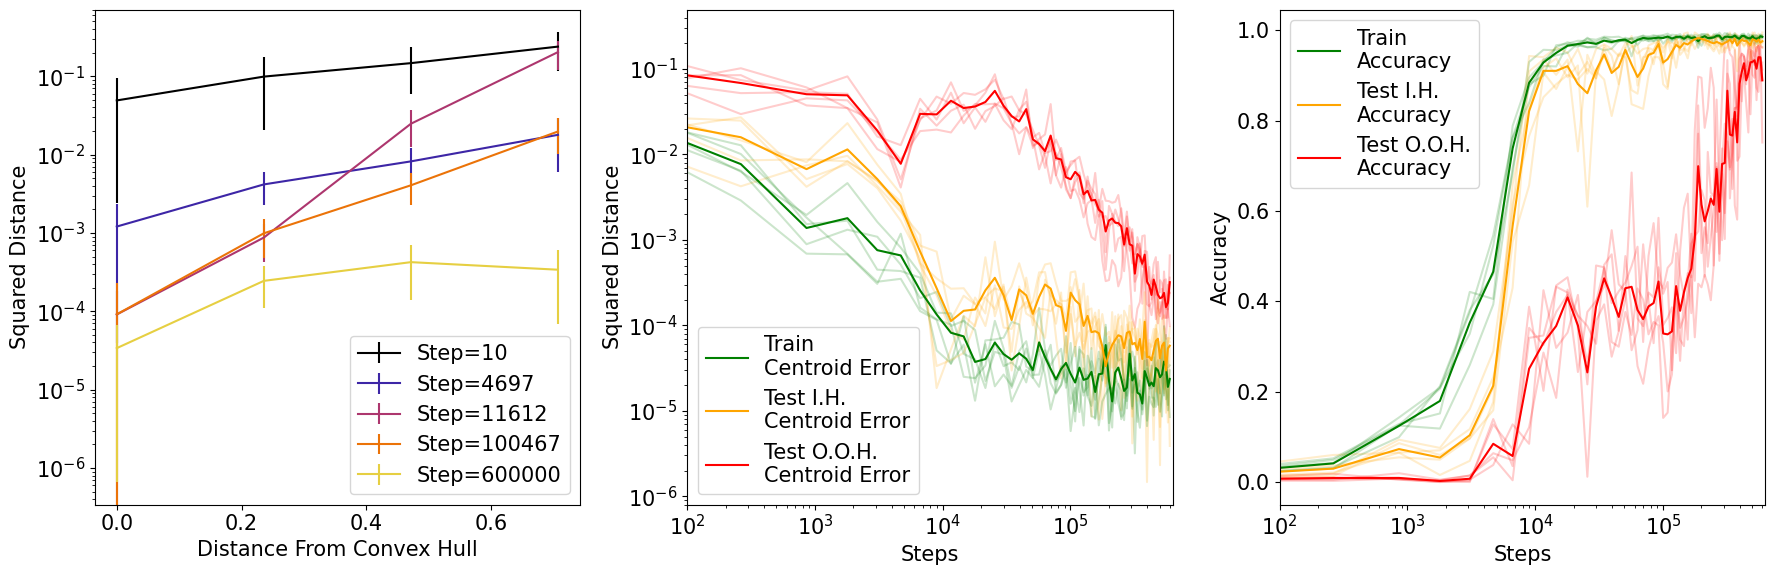

In [101]:
x_left=100

plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 15})
plt.subplot(1,3,1)

cmap=plt.get_cmap("CMRmap")
for count,i in enumerate([0,5,8,24,59]):
    bin_edges=np.append(uniques_from_hull-1e-3,np.inf)
    means_from_hull=sstats.binned_statistic(md_from_hull_,md_sqdist[:,i],statistic="mean",bins=bin_edges).statistic
    stds_from_hull=sstats.binned_statistic(md_from_hull_,md_sqdist[:,i],statistic="std",bins=bin_edges).statistic
    bin_edges=np.append(uniques_from_tri-1e-3,np.inf)
    means_from_tri=sstats.binned_statistic(md_from_tri_,md_sqdist[:,i],statistic="mean",bins=bin_edges).statistic
    stds_from_tri=sstats.binned_statistic(md_from_tri_,md_sqdist[:,i],statistic="std",bins=bin_edges).statistic

    plt.errorbar(uniques_from_hull,means_from_hull,yerr=stds_from_hull,label=f"Step={save_steps[i]}",color=cmap(count/5))
    #plt.errorbar(uniques_from_tri,means_from_tri,yerr=stds_from_tri)
plt.yscale("log")
plt.legend()
plt.xlabel("Distance From Convex Hull")
plt.ylabel("Squared Distance")

plt.subplot(1,3,2)
tri_sqdist=[]
inh_sqdist=[]
ooh_sqdist=[]
for i,plot_data in enumerate(plot_datas):
    save_steps=plot_data["save_steps"]
    tri_sqdist_=[]
    for i in tri:
        dist=plot_data["means_sqdist_perclass"][i]
        tri_sqdist_.append(dist)
    tri_sqdist_=np.array(tri_sqdist_).mean(0)
    plt.plot(save_steps,tri_sqdist_,c="green",alpha=0.2)
    tri_sqdist.append(tri_sqdist_)
    inh_sqdist_=[]
    for i in i_in_hull:
        dist=plot_data["means_sqdist_perclass"][i]
        inh_sqdist_.append(dist)
    inh_sqdist_=np.array(inh_sqdist_).mean(0)
    plt.plot(save_steps,inh_sqdist_,c="orange",alpha=0.2)
    inh_sqdist.append(inh_sqdist_)
    ooh_sqdist_=[]
    for i in i_out_of_hull:
        dist=plot_data["means_sqdist_perclass"][i]
        ooh_sqdist_.append(dist)
    ooh_sqdist_=np.array(ooh_sqdist_).mean(0)
    plt.plot(save_steps,ooh_sqdist_,c="red",alpha=0.2)
    ooh_sqdist.append(ooh_sqdist_)
trisqdm=np.array(tri_sqdist).mean(0)
plt.plot(save_steps,trisqdm,c="green",label="Train\nCentroid Error")
inhsqdm=np.array(inh_sqdist).mean(0)
plt.plot(save_steps,inhsqdm,c="orange",label="Test I.H.\nCentroid Error")
oohsqdm=np.array(ooh_sqdist).mean(0)
plt.plot(save_steps,oohsqdm,c="red",label="Test O.O.H.\nCentroid Error")
plt.xlim(left=x_left)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel(r"Squared Distance")
plt.legend()

plt.subplot(1,3,3)
tri_accs=[]
inh_accs=[]
ooh_accs=[]
for i,plot_data in enumerate(plot_datas):
    save_steps=plot_data["save_steps"]
    tri_accs_=[]
    for i in tri:
        acc=plot_data["accs_perclass"][i]
        tri_accs_.append(acc)
    tri_accs_=np.array(tri_accs_).mean(0)
    plt.plot(save_steps,tri_accs_,c="green",alpha=0.2)
    tri_accs.append(tri_accs_)
    inh_accs_=[]
    for i in i_in_hull:
        acc=plot_data["accs_perclass"][i]
        inh_accs_.append(acc)
    inh_accs_=np.array(inh_accs_).mean(0)
    plt.plot(save_steps,inh_accs_,c="orange",alpha=0.2)
    inh_accs.append(inh_accs_)
    ooh_accs_=[]
    for i in i_out_of_hull:
        acc=plot_data["accs_perclass"][i]
        ooh_accs_.append(acc)
    ooh_accs_=np.array(ooh_accs_).mean(0)
    plt.plot(save_steps,ooh_accs_,c="red",alpha=0.2)
    ooh_accs.append(ooh_accs_)
triaccm=np.array(tri_accs).mean(0)
plt.plot(save_steps,triaccm,c="green",label="Train\nAccuracy")
inhaccm=np.array(inh_accs).mean(0)
plt.plot(save_steps,inhaccm,c="orange",label="Test I.H.\nAccuracy")
oohaccm=np.array(ooh_accs).mean(0)
plt.plot(save_steps,oohaccm,c="red",label="Test O.O.H.\nAccuracy")
plt.xlim(left=x_left)
plt.xscale("log")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("./figures/ih_ooh_eval.png")

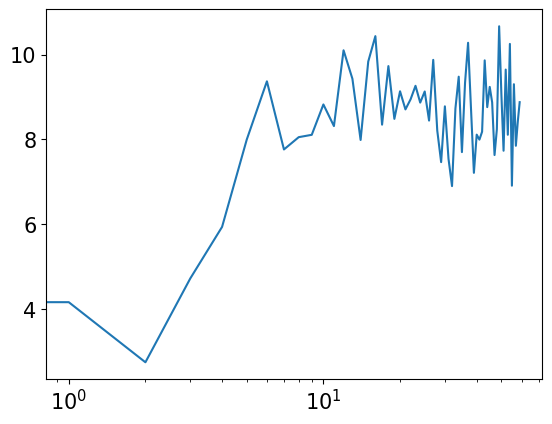

In [45]:
plt.plot(losses_perclass[0]["diffusion_loss"].mean(1))
plt.xscale("log")

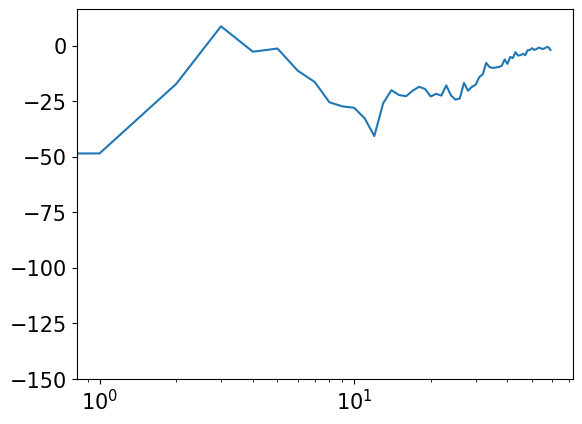

In [46]:
plt.plot((inhl-min_vlb)-(tel-min_vlb))
plt.xscale("log")

In [47]:
inhl

array([ 4.8129639e+03,  3.7439888e+03,  2.1567551e+03,  8.9283661e+02,
        2.7211621e+02,  5.8893963e+01,  1.0835108e+01,  5.1453676e+00,
        1.4655301e+01,  1.4932333e+01,  2.1085981e+01,  2.6637035e+01,
        4.2219368e+01,  2.7212534e+01,  2.1311497e+01,  1.7413206e+01,
        2.0023827e+01,  9.4194374e+00,  6.9839377e+00,  5.2207489e+00,
        6.2836556e+00,  2.4439549e+00,  1.1087196e+00, -1.0697619e+00,
       -5.6247473e-01, -4.2200541e-01, -8.3124465e-01, -2.4418349e+00,
       -1.7921627e+00, -2.2855048e+00, -1.7137054e+00, -3.0873182e+00,
       -3.2778695e+00, -3.4308448e+00, -3.0562606e+00, -3.1123099e+00,
       -2.8838315e+00, -2.5122344e+00, -2.9718976e+00, -3.3534341e+00,
       -2.8223832e+00, -2.7805333e+00, -3.4458134e+00, -2.7284837e+00,
       -3.0194259e+00, -3.0343921e+00, -3.2027371e+00, -2.7036853e+00,
       -3.0333161e+00, -3.1626475e+00, -3.1300302e+00, -2.7353222e+00,
       -2.0173006e+00, -2.1311524e+00, -1.9636692e+00, -2.7146635e+00,
      

In [48]:
tel

array([ 4.95544429e+03,  3.79245806e+03,  2.17393821e+03,  8.84062125e+02,
        2.74786439e+02,  6.01453659e+01,  2.20146396e+01,  2.14548294e+01,
        4.01141272e+01,  4.22149124e+01,  4.90056436e+01,  5.92856461e+01,
        8.28771040e+01,  5.31056629e+01,  4.13179295e+01,  3.95832193e+01,
        4.27090528e+01,  2.95877579e+01,  2.54191585e+01,  2.47082340e+01,
        2.91102653e+01,  2.40612096e+01,  2.35335262e+01,  1.67629505e+01,
        2.17613720e+01,  2.38254314e+01,  2.28861378e+01,  1.42554921e+01,
        1.84462146e+01,  1.62091313e+01,  1.58253199e+01,  1.10378994e+01,
        9.55253706e+00,  4.28339016e+00,  6.50610626e+00,  6.88398776e+00,
        6.87860956e+00,  7.06610981e+00,  6.00656234e+00,  2.77799035e+00,
        5.36441437e+00,  2.27799659e+00,  2.07189046e+00,  1.50343074e-01,
        1.37753476e+00,  1.20303798e+00,  4.17399035e-01,  1.52461527e+00,
       -9.89886845e-01, -1.28213452e+00, -2.04882282e+00, -8.68278256e-01,
       -4.91061728e-01, -

In [33]:
loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none")[1]#decomposed loss
loss_tr["elbo"].mean(),loss_tr["reconstruction_loss"].mean(),loss_tr["diffusion_loss"].mean(),loss_tr["latent_loss"].mean()

(tensor(-5.2168, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-7.6673, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.3538, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>))

In [39]:
e=0
r=0
d=0
l=0
nb=len(x_tr_torch)//32
for i in range(nb):
    loss_tr=model.get_loss(x=x_tr_torch[i*32:(i+1)*32],c=y_tr_torch[i*32:(i+1)*32],reduction="none")[1]#decomposed loss
    e+=loss_tr["elbo"].mean().item()
    r+=loss_tr["reconstruction_loss"].mean().item()
    d+=loss_tr["diffusion_loss"].mean().item()
    l+=loss_tr["latent_loss"].mean().item()
e=e/nb
r=r/nb
d=d/nb
l=l/nb
e,r,d,l

(-5.309890483106885,
 -7.670690843037197,
 2.264083193881171,
 0.09671712201088667)

In [36]:
ckpt_path

'data/base/seed=0/ckpts/ckpt_step=600000.pth'

In [247]:
loss_class.keys()

dict_keys(['elbo', 'diffusion_loss', 'latent_loss', 'reconstruction_loss'])

In [29]:
config["batch_size"]

32

In [203]:
ls=last_losses[i_out_of_hull]
lam=np.argmax(ls)
lam,i_out_of_hull[lam],ls[lam]

(5, 15, 12.449688)

(100, 1040061.0031356352)

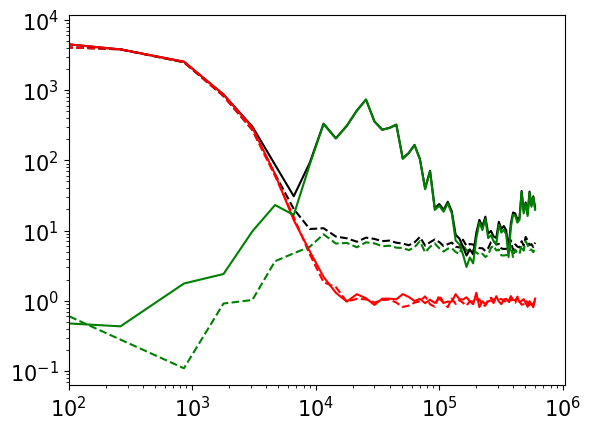

In [208]:
minvlb=plot_data["min_vlb"]
plt.plot(plot_data["save_steps"],plot_data["losses_perclass"][1]["elbo"].mean(1)-minvlb,ls="--",c="black")
plt.plot(plot_data["save_steps"],plot_data["losses_perclass"][1]["reconstruction_loss"].mean(1)-minvlb,ls="--",c="red")
#plt.plot(plot_data["save_steps"],plot_data["losses_perclass"][1]["latent_loss"].mean(1),ls="--",c="blue")
plt.plot(plot_data["save_steps"],plot_data["losses_perclass"][1]["diffusion_loss"].mean(1),ls="--",c="green")


i_out=15
plt.plot(plot_data["save_steps"],plot_data["losses_perclass"][i_out]["elbo"].mean(1)-minvlb,ls="-",c="black")
plt.plot(plot_data["save_steps"],plot_data["losses_perclass"][i_out]["reconstruction_loss"].mean(1)-minvlb,ls="-",c="red")
#plt.plot(plot_data["save_steps"],plot_data["losses_perclass"][15]["latent_loss"].mean(1),ls="-",c="blue")
plt.plot(plot_data["save_steps"],plot_data["losses_perclass"][i_out]["diffusion_loss"].mean(1),ls="-",c="green")

plt.yscale("log")
plt.xscale("log")
plt.xlim(left=100)

In [292]:
ckpts=plot_data["ckpts"]
ckpt_keys=ckpts[0].keys()
tckpt={}
for key in ckpt_keys:
    if "model.score_model" not in key:
        continue
    key_=key.replace("model.score_model.","")
    tckpt[key_]=[]
    for ckpt in ckpts:
        tckpt[key_].append(ckpt[key])  
    tckpt[key_]=torch.stack(tckpt[key_],axis=0).cpu().numpy()
    print(key_,tckpt[key_].shape)

embed_t_conditioning.0.weight (60, 256, 64)
embed_t_conditioning.0.bias (60, 256)
embed_t_conditioning.2.weight (60, 256, 256)
embed_t_conditioning.2.bias (60, 256)
embedders.0.0.0.weight (60, 1024, 256)
embedders.0.0.0.bias (60, 1024)
embedders.0.0.2.weight (60, 1024, 1024)
embedders.0.0.2.bias (60, 1024)
embedders.0.1.0.weight (60, 1024, 2)
embedders.0.1.0.bias (60, 1024)
embedders.0.1.2.weight (60, 1024, 1024)
embedders.0.1.2.bias (60, 1024)
layers.0.weight (60, 1024, 2)
layers.0.bias (60, 1024)
layers.1.weight (60, 2, 1024)
layers.1.bias (60, 2)


In [293]:
tckpt['embedders.0.1.2.weight'].shape

(60, 1024, 1024)

In [294]:
eigvs=np.linalg.eigvals(tckpt['embedders.0.1.2.weight'])
eigvs.shape

(60, 1024)

In [295]:
eigvs_abs=np.abs(eigvs)**2

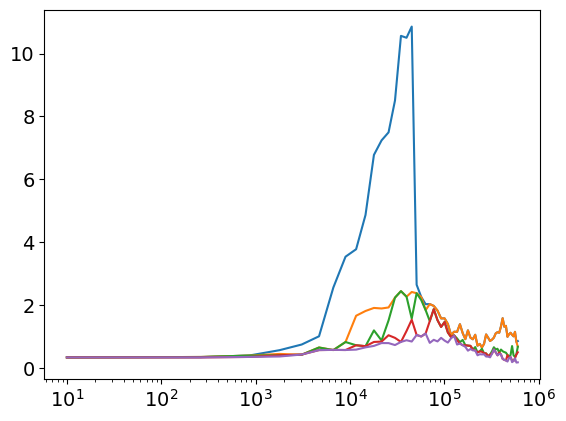

In [305]:
#plt.plot(save_steps,eigvs_abs[:,0])
plt.plot(save_steps,eigvs_abs[:,1])
plt.plot(save_steps,eigvs_abs[:,2])
plt.plot(save_steps,eigvs_abs[:,3])
plt.plot(save_steps,eigvs_abs[:,4])
plt.plot(save_steps,eigvs_abs[:,5])
plt.xscale("log")

In [270]:
def mMn(vals):
    m=vals.min()
    M=vals.max()
    return (vals-m)/(M-m)

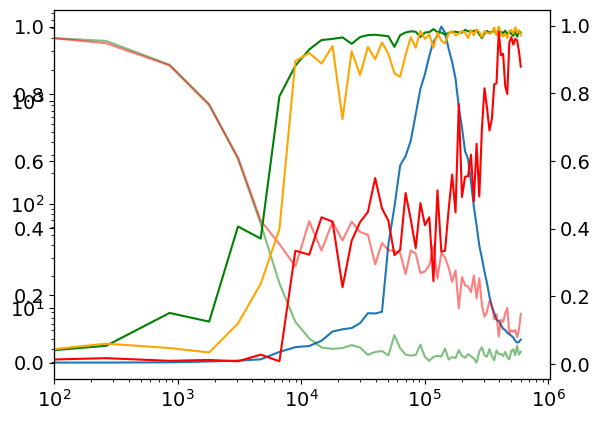

In [303]:
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.weight'][:,:,0],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.bias'][:,:],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.2.bias'][:,:],axis=1))
plt.plot(save_steps,mMn(eigvs_abs[:,0]))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.weight'][:,:,0],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.bias'],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.1.bias'],axis=1)))
plt.xscale("log")
plt.xlim(left=x_left)
plt.twinx()
plt.plot(save_steps,val_losses-min_vlb,c="green",alpha=0.5)
plt.plot(save_steps,te_losses-min_vlb,c="red",alpha=0.5)
plt.yscale("log")
plt.twinx()
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
#plt.plot(save_steps,acctr_m,c="green",ls="--")
#plt.plot(save_steps,accte_m,c="red",ls="--")


In [161]:
#for fol in glob.glob("./data/images_1/circle/*"):
for fol in glob.glob("./data/data_noise/dn=0.1*"):
#for fol in glob.glob("./data/perdim=5/seed=0"):
    config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_file)
    logs_file=os.path.join(fol,"logs.pth")
    logs=torch.load(logs_file)
    min_vlb=logs["min_vlb"]
    break
min_vlb

-1.9961800301512027

In [162]:
#min_vlb=model.__class__.get_min_vlb_(data_noise=1e-3,n_dim=1)

In [163]:
save_steps=logs["save_steps"]
losses=np.array(logs["losses"])
val_losses=np.array(logs["val_losses"])
te_losses=np.array(logs["te_losses"])

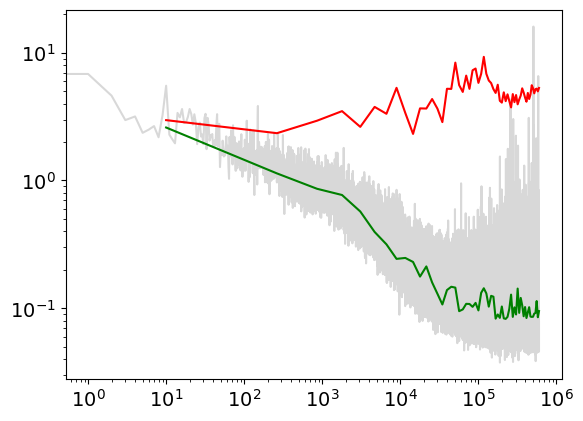

In [164]:
plt.plot(losses-min_vlb,c="gray",alpha=0.3)
plt.plot(save_steps,val_losses-min_vlb,c="green")
plt.plot(save_steps,te_losses-min_vlb,c="red")
plt.yscale("log")
plt.xscale("log")

In [103]:
model.__class__.get_min_vlb_(data_noise=1e-3,n_dim=1)

-8.640036219925928

In [61]:
data_noise=1e-4
n_dim=8
np.log(2*np.pi*(data_noise**2))/(2*np.log(2))

-11.96196431481329